In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Div
from bokeh.layouts import row, grid, layout, gridplot


output_notebook()
pd.options.display.float_format = '{:,.5f}'.format
HTML('<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css">')
# HTML('<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">')

Loading BokehJS ...

# USTC Team CEX Proposal

Our team blends traditional finance and innovative blockchain expertise. One of our team members boasts 15 years in Investment Banking, specializing in quantitative development, and several years of working with various DEFI protocols. Another one worked for 13 years as an analyst, portfolio manager, and principal at several elite hedge funds, and worked full-time as a senior product manager at a web3 startup. We believe we offer a rare blend of skill and experience in both TradFi and DeFi, as well as significant experience with the Terra Protocol both before & after its May 2022 collapse.

We have been engaged by the Luna Classic Community via governance to find ways to make USTC a working stablecoin product again.

We believe that the web3 world’s dependence on USDT as a unit of stable account is dangerously unsustainable. Just as the capital efficiency of broad banks has allowed them to capture the large majority of USD circulation share, we believe the capital efficiency of decentralized algorithmic stablecoins will, in the long run, allow them to capture market share from the narrow-banking model of USDT/USDC.

We are interested in engaging with LUNC’s main CEX partners (the major ones and a handful of nation-specific CEXs) on ways to burn off excess USTC supply, and shrink the circulating supply of USTC much closer to its circulating market cap, thus driving the price of USTC much closer to \$1. 

To that end, we’ve primarily focused on what the LUNC community calls the **Divergence Protocol**, a system to buy back and protect the peg by taxing short sellers and leveraging off-chain arbitrage. 

### PART 1: The divergence protocol and buy back algorithm

We wish to introduce a novel mechanism to handle stable coins in the decentralized finance ecosystem. At its core, the proposal seeks to stabilize the value of the USTC coin to ensure it remains pegged to a set value.

**Mechanism Overview**:

- **Tax Mechanism**: The protocol leverages an innovative arbitrage tax mechanism, where USTC is taxed based on the impact a particular DEX trade would have on its value in xyk DEX pools. This mechanism is inspired by TFL's capital control tax, which was effectively used during market crashes.

- **Setting a Target Price**: The Divergence Protocol sets a target price that's marginally higher than the prevailing market price. This target price acts as a benchmark, and the divergence from this target is used to calculate the tax rate for a particular trade.

- **Trade Execution**: The Constant Product Automated Market Maker (AMM) mechanism, a popular method in decentralized finance, was employed to simulate trade execution.


<img src="https://docs.uniswap.org/assets/images/trade-b19a05be2c43a62708ab498766dc6d13.jpg" width="450" style="display:inline"/> 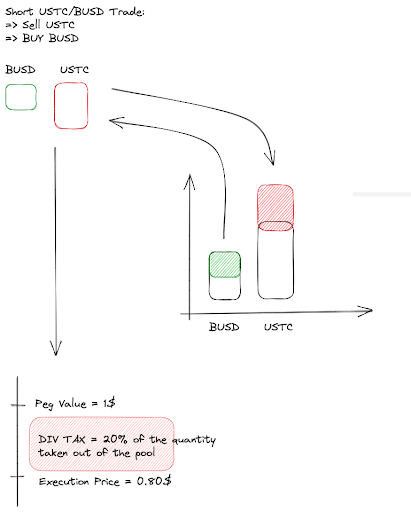


---

### PART 2: The role CEX/DEX play

CEX (Centralized Exchanges) and DEX (Decentralized Exchanges) play a pivotal role in the functioning and stabilization of the USTC protocol.

**How CEX/DEX Interact with USTC**:

- **Arbitrage Opportunities**: The tax mechanism creates arbitrage opportunities for traders. These arbitrage opportunities arise from the divergence between the set target price of USTC and its prevailing market price.

- **Tax Collection**: CEX and DEX platforms would be responsible for collecting the arbitrage tax and ensuring its proper distribution as per the divergence protocol guidelines.

- **Collaboration**: Share tools and insights, advancing the frontier of algo stables and decentralized money.

**Benefits for CEX/DEX**:

- **Revenue Stream**: The arbitrage tax serves as a new revenue stream for exchanges. A portion of this tax is allocated to the exchanges, providing them with a monetary incentive to support and integrate the USTC protocol.

- **Stabilization**: By actively participating in the USTC ecosystem, exchanges contribute to the stabilization of USTC, which in turn can lead to increased trading volumes and user trust.

---


### PART 3: Modeling and stress-testing

To ensure the robustness and reliability of the USTC protocol, extensive modeling and stress-testing have been conducted, as elaborated in the **DivProtocolStrategy** analysis.

**Modeling**:

- **Scenario Analysis**: Two strategies were simulated to gauge the protocol's response to different market conditions, including drastic price movements, sudden influx of trades, and prolonged market downturns. The **PnL Breakdown** offers insights into the stability of USTC, the performance of liquidity providing over time, the potential for transaction fees, and the risks of impermanent losses.
  
- **Tax Impact Analysis**: Models were created to understand how different tax rates impact the stability of USTC and the profitability of traders and exchanges. The **Mid Vs. Exec Price** analysis measures discrepancies between the liquidity pool's mid price and the trade execution price, indicating potential market inefficiencies or frequent arbitrage opportunities.
  
- **Market Dynamics & Arbitrage**: The model simulates market dynamics, providing insights into trading volumes, price impacts, and arbitrage profits. High trading volumes, as indicated in the **Volume (Quote)** analysis, can suggest significant market events or liquidity changes, while the **Price Impact** analysis highlights the efficiency of trades and the liquidity pool's depth.


**Base case simulation**:

The simple Uniswap V2 strategy integrates a CP-AMM for the trading execution. The strategy optionally includes an arbitrage mechanism that, when enabled, seeks and executes potential arbitrage opportunities. This allows to keep the mid price of the pools in line with the market price.

1. **Arbitrage Mechanism**: Arbitrage in this context refers to the practice of taking advantage of a price difference between two or more markets. For instance, if there's a discrepancy between the market price and the CP-AMM's price, an arbitrage trade can be executed to profit from this difference.
2. **Trade Execution Based on Quantity**: Trade orders are then passed to the CP-AMM for execution. The CP-AMM handles the trade, ensuring that it adheres to the constant product formula, and returns the information about the execution.
3. **Strategy Outcome**: The main outcome of the strategy's execution is a list of trade execution information. This list contains details of all trades executed during the strategy's operation, including any arbitrage trades and regular trades based on the simulation data's quantity.

---

**Model Parameters and Assumptions**:

- **Data Source:** Historical trade data is sourced from Binance for the market pair USTC/BUSD.

- **Date Range:** The data spans from January 1, 2023, to June 30, 2023.

- **Liquidity:** For both strategies, we assumed an initial liquidity of \$100,000 in the USTC/BUSD market.

---

In [2]:
from binance import Client
from terra_algo_backtest.utils import format_df
from terra_algo_backtest.plotting import new_trade_figure, plot_price_ratio
from terra_algo_backtest.binance_loader import new_binance_client

# Replace these with your Binance API key and secret
client = new_binance_client(os.getenv("BINANCE_API_KEY"), os.getenv("BINANCE_API_SECRET"))

mkt_pair = 'USTC/BUSD'
frequency = Client.KLINE_INTERVAL_1HOUR
start, end = '2023-01-01 00:00:00', '2023-06-30 23:59:59'
qty_factor = 0.01 # pct of binance historical volume

df_trades = client.get_trade_data(mkt_pair, frequency, start, end)
df_trades["quantity"] = qty_factor*df_trades["quantity"]

In [3]:
from terra_algo_backtest.market import MarketQuote, new_market
from terra_algo_backtest.simulation import swap_simulation
from terra_algo_backtest.plotting import new_simulation_figure
from terra_algo_backtest.plot_layout import div_layout
from terra_algo_backtest.exec_engine import ConstantProductEngine
from terra_algo_backtest.strategy import SimpleUniV2Strategy, DivProtocolStrategy, DivProtocolParams

liquidity_usd = 100_000
# USTC/BUSD market price
base = MarketQuote("USTC/BUSD", df_trades.price.iloc[0])
# BUSD/USD market price
quote = MarketQuote("BUSD/USD", 1)
# create a 1,000,000 USD market for USTC/BUSD with 0.3% swap fee 
mkt = new_market(liquidity_usd, quote, base, 0.003)
# create a cp swap execution engine
cp_amm = ConstantProductEngine(mkt)
# div protocol with buy back strategy on top the amm strat
strategy=SimpleUniV2Strategy(cp_amm, arb_enabled=True)
# run simulation
simul = swap_simulation(df_trades, strategy)
# display results
show(new_simulation_figure(mkt, simul))

Function 'trade_summary' executed in 0.0093s
Function 'sim_results' executed in 0.0980s
Function 'swap_simulation' executed in 0.4715s


**Observations**:

1. The PnL breakdown is visualized through three lines: 
- The Blue Line indicates Profit & Loss relative to the initial investment (e.g., a +1% shows a 1% profit on a 1M USD investment). 
- The Dashed Green Line shows accumulated transaction fees, acting as profit ceiling from fees.
- The Dashed Red Line represents the minimum profit boundary, showing losses from price differences exploited by arbitrageurs. 
2. The 24-hour trading volume, denoted in BUSD, shows spikes due to arbitrage when the market moves sharply. This obviously coincides with spikes in profits from arbitrage
3. Price Impact shows sharp market moves. That’s because we don’t optimize the execution and are happy to lose to slippage as long as the arb trade P&L remains positive. Something to improve for the next iterations.  
4. Volume from arbitrage (in red) and retail (in blue) shows that the toxic and retail flows are well balanced. This indicates a good level of liquidity.
5. Lastly, comparing actual trade P&L with theoretical Impermanent Loss (calculated by closed formula) checks the formula's accuracy and pool performance; significant mismatches could indicate trade execution issues or formula inaccuracies.


**Simulation of the divergence protocol with buy back**:

The DivProtocolStrategy wraps the SimpleUniV2 strategy, enhancing it with dividend protocol parameters. It maintains a reserve of base and quote assets. When executing trades, it first processes the underlying strategy's trades, applying a divergence tax calculation. Additionally, if the market price is below a designated peg price and there's a positive reserve, buy-back trades are executed, potentially stabilizing the market.

1. **Buy-Back Condition**: The strategy continuously checks if the mid price of the pool is below the specified `peg_price`. If this condition is met and there's a positive reserve, a buy-back trade is considered.

2. **Reserve**: The strategy maintains a reserve that accumulates over time due to the dividend tax mechanism. This reserve can be in the form of base and/or quote assets. 

3. **Buy-Back Trade Calculation**: If the buy-back conditions are met, the strategy calculates the amount of the buy-back trade. This function determines the amount of the asset to buy back, how much of the reserve to use, and if there's a need to borrow any additional assets.

4. **Buy-Back Execution**: If a buy-back trade is determined, the strategy proceeds to execute the buy-back against the pool.

5. **Stabilization Objective**: The main objective behind the buy-back mechanism is to provide price stability. By buying back assets when the price is below the peg, the strategy exerts upward pressure on the price, helping it move closer to the peg price. This action can help reduce price volatility and maintain the asset's price closer to its intended peg.

In summary, the buy-back mechanism in the `DivProtocolStrategy` acts as a stabilizing force. By utilizing the accumulated reserve to purchase assets when their price is below the peg, the strategy aims to mitigate drastic price drops and maintain the asset's value closer to its intended peg price.

---

**Model Parameters and Assumptions**:

- **Data Source:** Historical trade data is sourced from Binance for the market pair USTC/BUSD.

- **Date Range:** The data spans from January 1, 2023, to June 30, 2023.

- **Liquidity:** For both strategies, we assumed an initial liquidity of \$100,000 in the USTC/BUSD market.

- **Peg Price:** 0.015\$

---

In [4]:
from terra_algo_backtest.market import MarketQuote, new_market
from terra_algo_backtest.simulation import swap_simulation
from terra_algo_backtest.plotting import new_simulation_figure
from terra_algo_backtest.plot_layout import div_layout
from terra_algo_backtest.exec_engine import ConstantProductEngine
from terra_algo_backtest.strategy import SimpleUniV2Strategy, DivProtocolStrategy, DivProtocolParams

liquidity_usd = 100_000
# USTC/BUSD market price
base = MarketQuote("USTC/BUSD", df_trades.price.iloc[0])
# BUSD/USD market price
quote = MarketQuote("BUSD/USD", 1)
# create a 1,000,000 USD market for USTC/BUSD with 0.3% swap fee 
mkt = new_market(liquidity_usd, quote, base, 0.003)
# create a cp swap execution engine
cp_amm = ConstantProductEngine(mkt)
# div protocol with buy back strategy on top the amm strat
strategy = DivProtocolStrategy(
    strategy=SimpleUniV2Strategy(cp_amm, arb_enabled=True),
    strat_params=DivProtocolParams(peg_price=0.015),
)
# run simulation
simul_div = swap_simulation(df_trades, strategy)
# display results
show(new_simulation_figure(mkt, simul_div, sim_layout_fn=div_layout))

Function 'trade_summary' executed in 0.0097s
Function 'sim_results' executed in 0.1421s
Function 'swap_simulation' executed in 0.9274s


**Main observations**:

1. We see that the buy back helps keep the price at peg while the benchmark price drops under (in red dash). We also see the impermanent loss flattening at and under the peg.
2. Most of the divergence tax is collected as we depeg towards the end. However we also tax being collected even though the price hasn’t depegged. This is due to the arbitrage: Tax is collected if a trade pushes the mid price under the peg. But then the arbitrage manages to push it back up so we don’t need to buy back, price ends up at peg but we have collected some tax.
3. We see a massive volume during repeg but the buy back volume only accounts for half of it. So where does the other half come from ? It turns out that as we buy back, we create an arbitrage opportunity: The price in our DEX is now at peg and therefore higher than the market price. So arbers bring it back down. Generating more tax and therefore more buy back. And so on. That’s an interesting effect which was unaffected and is akin to an arb infinite loop. This effect is very interesting and we will investigate it more. 
4. This translates into a massive P&L for the liquidity providing position which explodes around depeg. Indeed depeg generates volume with the buy back which is further amplified with the arb effect we mentioned previously. But as we saw, it also cancels the impermanent or at least flattens at or under the peg. So we’re basically limiting the impermanent loss while increasing transaction fees.
5. We see that the both portfolio values are flat and have dropped. That's because we picked a peg value (0.015 USD) below the value when we provided liquidity (at the begining of the simulation). Most important thing here to remember is that both the hold and LP value are the same or very close. Not surprising since the impermanent has been cancelled. 


---

### Conclusion

In this document we have provided comprehensive modeling and rigorous stress-testing for the divergence protocol to test the performance of the algo stable strategy. The **Scenario Analysis** and **Tax Impact Analysis** provided deep insights into the protocol's resilience against abrupt market fluctuations and its potential to stabilize USTC with a tax and buy back strategy.  

A significant observation was how the **DivProtocolStrategy** uses a buy-back mechanism, harnessing accumulated reserves to counteract price drops and stabilize the asset closer to its peg. This strategy seems effective, as evidenced by the asset's maintained price during significant benchmark price drops.

However, a few risks and anomalies were identified.

**Risks and Considerations**:

1. **Impact on Trading Volume**: We need to collect taxes. On the other hand taxing will clearly have an impact on trading volume. So the main risk here is that people get detered by the tax. This can be mitigated by taxing outside a range rather than at peg. This mechanism will be more easily accepted if the tax kick outside a range [0.70 USD,1.20 USD] for example. But then we won't collect as much tax. Another avenue to explore here is to center the tax around arbitrage trades.

2. **Arbitrage Effects**: The interaction between tax collection, mid-price fluctuations, and arbitrage activities can sometimes create a feedback loop. This "arb infinite loop" effect can amplify trading volumes and can be both a boon and a bane, warranting further investigation.
   
3. **Impermanent Loss vs. Transaction Fees**: The observations indicate that while the protocol manages to limit impermanent loss, especially during depegging, it significantly boosts transaction fees. This balancing act between limiting losses and increasing fees demonstrates the protocol's dual-edged nature.

4. **Tax Collection Anomalies**: The collection of divergence tax during non-depegging situations, due to arbitrage activities pushing the mid-price, showcases potential inefficiencies in the system. While this may not lead to buy-backs, it's a factor that could influence trader sentiment and behavior.

5. **Dependence on Historical Data**: Like all backtesting approaches, our results are based on past market conditions. Future performance can vary based on a multitude of unpredictable factors.  

6. **Liquidity Concerns**: While we assumed a fixed initial liquidity, real-world scenarios can see varying liquidity levels, which might impact strategy performance.

7. **Strategy Complexity**: The DivProtocolStrategy is more intricate than the SimpleUniV2Strategy. While this can offer more nuanced trading decisions, it also means there are more parameters and conditions to monitor and adjust.

In essence, while the USTC protocol has shown promise in maintaining price stability and offering lucrative opportunities for liquidity providers, it's essential to be cautious. The intricate interplay between various strategies, especially during high-volume events, may lead to unforeseen consequences. Continuous monitoring, periodic reviews, and iterative improvements will be crucial in ensuring the protocol's long-term success and safeguarding against potential market risks.

---